## 1.  Introduction
Based on a medical patient’s biopsy, it needs to be determined whether the investigated tissue contains malignant, i. e. cancer cells. In order to react to the growth of cancer cells quickly and appropriately, it is necessary to define such cells at an early state. A Machine Learning model can be able to identify breast cancer reliably for a given sample. The classification is itself based on a defined set of cytology features from biopsies, such as shape and size. As a result, cytology features obtained from biopsies enable a Machine Learning model to provide an effective, accurate and fast diagnosis. 

## 2. Pre - processing of data  

In preparation, we import required libraries for mathematics, plotting and text processing:

In [6]:
import io
import os

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

and additionally, SageMaker specific libaries, which are used for setting up session variables, which will be used later on: 

In [7]:
import boto3
import sagemaker
from sagemaker import get_execution_role
#Obtain Sagemaker session
session=sagemaker.Session()
#Sagemaker default execution role
role=sagemaker.get_execution_role()
#Set S3 bucket variable
bucket=session.default_bucket()

The original data  .csv file is read in as DataFrame:

In [17]:
file_path='data/datasets_17259_22663_wisconsin_breast_cancer.csv'

file_df=pd.read_csv(file_path)
print(file_df.shape)
file_df.head()

(699, 11)


,id,thickness,size,shape,adhesion,single,nuclei,chromatin,nucleoli,mitosis,class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0


In preparation to further processing, rows with null values, duplicates are dropped and the column with identifiers is removed. Further indexing of data will be done by row numbers. 

In [73]:
#remove null values and duplicates
file_df=file_df.dropna()
print('After removal of samples with null values:', file_df.shape)
file_df=file_df.drop_duplicates()
print('After removal of duplicates:', file_df.shape)
file_df.head()
df_total=file_df
# Remove IDs
file_df=file_df.drop(columns='id')

After removal of samples with null values: (675, 10)
After removal of duplicates: (449, 10)


KeyError: "['id'] not found in axis"

After this, let's first check the ratio between the different data samples

In [1096]:
#Explore data classification 
value_counts=file_df['class'].value_counts()
print('Total samples with malignant tumor', value_counts[1]) 

percentage_malignant=value_counts[1]/(value_counts[0]+value_counts[1])
print('Percentage with malignant tumor', percentage_malignant) 

percentage_benign=value_counts[0]/(value_counts[0]+value_counts[1])
print('Total samples with benign tumor', value_counts[0]) 
print('Total samples with benign tumor', percentage_benign) 

Total samples with malignant tumor 236
Percentage with malignant tumor 0.3496296296296296
Total samples with benign tumor 439
Total samples with benign tumor 0.6503703703703704


## 3. Data exploration
For illustration purposes, distribution of data samples will be plotted with respect to two features (pairwise). Images are stores as .png files in a folder 'pictures'. It can be noticed, that the features are roughly distributed in the different quadrants; however, the each feature pair also contains a few outliers. 

In [1097]:
# For viewing plots in notebook, uncomment plt.show()
def plot_feature_distribution(df,column_pos_1, column_pos_2):
    '''Create a scatter plot for two different features and a given DataFrame of relevant input data
       :param df: Dataframe of original data set that includes features and binary labels, i.e. in this case 
                  0=benign and 1=malignant probes)
       :column_pos_1: First feature to be used in plot
       :column_pos_2: Second feature to be used in plot
       '''
    x_dat=df.iloc[:,column_pos_1]
    y_dat=df.iloc[:,column_pos_2]
    x_label=df.columns.values[column_pos_1]
    y_label=df.columns.values[column_pos_2]
    #Color is determined by cell classification
    color_c=df.iloc[:, -1]
    scatter = plt.scatter(x_dat,y_dat,c=color_c)
    title='Sample distribution for ' + x_label+' and '+ y_label
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    #plt.show()
    plt.savefig('pictures/'+ title +'.png') 

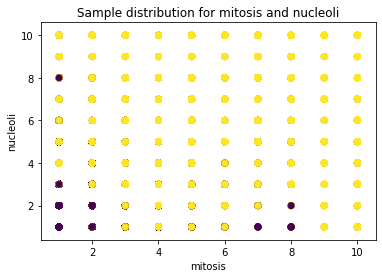

In [1377]:
for i in range(9):
    for j in range(9):
        if i!=j: 
            plot_feature_distribution(file_df, i, j)

Interesting is also to question whether any two of these features are highly correlated and could be omitted, for example, when establishing a "standardized" cancer diagnosis procedure based on image data:    

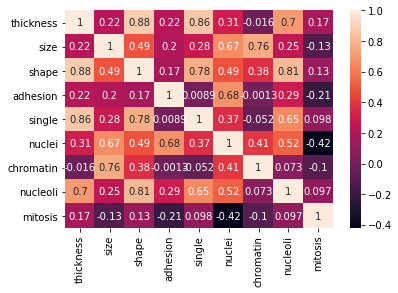

In [1375]:
import seaborn as sbn

feat_corr=np.corrcoef(file_df.values[0:9])
labels=file_df.keys()
labels=labels[0:9]
sbn.heatmap(feat_corr, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

## 4. Data preparation
A training, test and validation data set is prepared for further steps. The order of the data set is randomized and data is partitioned. The 'class' column,  which provides a vector of labels, is separated.   

In [74]:
def train_test_split(file_df, train_frac= 0.5, valid_frac=0.0, seed=1):
    '''Shuffle the samples and split into train and test sets using the seed function for randomizing;
       separate the data classification from the features into a vector of labels.
       :param file_df: Dataframe of original data set that includes features and labels.
       :param train_frac: The decimal fraction of data that should be training data
       :param valid_frac: The decimal fraction of data that should be validation data, default no validation
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # convert the df into a matrix for ease of splitting
    df_matrix = file_df.to_numpy()
    
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    
    #first ratio provides training data 
    train_size = int(df_matrix.shape[0] * train_frac)
    train_features  = df_matrix[:train_size, :-1]
    train_labels = df_matrix[:train_size, -1]
    validation_size = int(df_matrix.shape[0] * (train_frac+valid_frac))
    
    if validation_size > 0:
        # second ratio provides test data
        test_features = df_matrix[train_size:validation_size, :-1]
        test_labels = df_matrix[train_size:validation_size, -1]
        # third ratio provides validation data
        validation_features = df_matrix[validation_size:, :-1]
        validation_labels = df_matrix[validation_size:, -1]
    else:
        test_features = df_matrix[train_size:, :-1]
        test_labels = df_matrix[train_size:, -1]
        validation_features=np.array('empty')
        validation_labels=np.array('empty')
    
    return (train_features, train_labels), (test_features, test_labels), (validation_features, validation_labels)


This method is appied to the pre-processed data, in order to separate train and test features and corresponding labels:

In [75]:
(train_features, train_labels), (test_features, test_labels), (validation_features, validation_labels)=train_test_split(file_df,train_frac=0.5,valid_frac=0.25)

In [1104]:
print('records in training set: ',train_features.shape[0])
print('records in testing set: ',test_features.shape[0])
print('records in validation set: ',validation_features.shape[0])

records in training set:  337
records in testing set:  169
records in validation set:  169


Next, the record sets are prepared as csv files and uploaded to S3 directory.

In [77]:
def data_as_txt(name, features, labels=None):
    ''' Method that combines features and labels to a .csv file and stores in s3 default bucket. 
        param features: Feature samples
        param labels: Class labels corresponding to features. These will be inserted in first column, as required for XGBoost. 
                      Can be empty, to account for test features.   
        param name: Name under which the respective file should be stored. 
    '''
    df1=pd.DataFrame(features)
    if labels is not None:
        df2 = pd.DataFrame(labels)   
        frames=[df2,df1]
        df=pd.concat(frames, axis=1)
    else:
        df=df1
#save locally
#tbd check path exists
    path_loc = os.path.join('data/', name)
   
    df.to_csv(path_loc,index=False, header=False)
#save in S3 bucket
    prefix='WBCD'
    session.upload_data(path_loc, bucket, prefix)
    
    path_s3=os.path.join('s3://', bucket, prefix, name)
    print(path_s3)
#return path to S3 bucket
    return path_s3

In [78]:
# path to training data in S3 bucket
path_s3 = data_as_txt(name='train.csv',features= train_features, labels=train_labels)
# path to validation data in S3 bucket
path_s3_val = data_as_txt(name='validation.csv', features=validation_features,labels=validation_labels)
#path to test data in S3 bucket
path_s3_test = data_as_txt(name='test.csv', features=test_features)

s3://sagemaker-eu-central-1-237055357929/WBCD/train.csv
s3://sagemaker-eu-central-1-237055357929/WBCD/validation.csv
s3://sagemaker-eu-central-1-237055357929/WBCD/test.csv


Finally, we define a function for the evaluation metrics which are in focus of this investigation, namely, accuracy, specificity, and recall. The function stores all results including further information in a separate file of results. 

In [1336]:
def eval_metrics(test_labels, test_predictions, estimator=None):
    ''' Function which evaluates accuracy, specificity and recall of the data and saves results, 
        complemented by hyperparameters, to a csv file
        param test_labels: the correct labels of original test data
        param test_predictions: the predicted labels of the test data
        param estimator: the estimator that was used, details on hyperparameters will be appended to the results
    '''
    tp = np.logical_and(test_labels, test_predictions).sum()
    fp = np.logical_and(1-test_labels, test_predictions).sum()
    tn = np.logical_and(1-test_labels, 1-test_predictions).sum()
    fn = np.logical_and(test_labels, 1-test_predictions).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    specitivity= tn / (fn + tn)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    print("Accuracy: ", accuracy)
    print("Specificity: ", specitivity)
    print("Recall: ", recall)
    
    estimator_class=estimator.__class__.__name__
    
    f=csv.writer(open('evaluation/metrics.csv','a+'))
    f.writerow(["Evaluation metrics using", estimator_class ])
    f.writerow(["Accuracy", accuracy])
    f.writerow(["Specificity: ", specitivity])
    f.writerow(["Recall", recall])
    f.writerow(["Estimator parameters:",])
    
    if estimator_class =='XGBRegressor':        
        d=estimator.get_params()
    elif estimator_class =='Estimator':
        d=estimator.hyperparameters()
    else: 
        d={'Estimator_Obj':'unknown estimator'}
        
    for key, val in d.items():
        f.writerow([key , val])
   

### 3. Scikit XGBoost
For an initial investigation of parameters that cannot be checked by using a hyperparameter training, a first "quick" check can be done using the xgboost package, see also https://xgboost.readthedocs.io/en/latest/python/python_intro.html. 
This may need to be pip-installed on the notebook.

In [58]:
#local installation of xgboost
import pip
pip.main(['install', 'xgboost'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


0

In [1329]:
from xgboost import XGBRegressor

We first set up and train the XGBooster for different combinations of: 
- booster:'dart', 'gblinear', 'gbtree'
- evaluation metrics: 'mae', 'RMSE', 'error','mlogloss'
- tree method: 'auto', 'exact', 'approx', 'hist'

In [1330]:
#booster:'dart', 'gblinear', 'gbtree'
#eval_metrix: ['mae', 'RMSE', 'error','mlogloss']),
#'tree method': ['auto', 'exact', 'approx', 'hist']
xgb_reg=XGBRegressor(
            base_score=0.5, 
            booster='gblinear', 
            objective='binary:hinge',
            eval_metric='mae',
            tree_method='hist',
            validate_parameters=1
)

In [1331]:
xgb_reg.fit(train_features, train_labels)

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='mae',
              gamma=None, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.5,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=0, num_parallel_tree=None, objective='binary:hinge',
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=None,
              subsample=None, tree_method='hist', validate_parameters=1,
              verbosity=None)

For each parameter combination, we predict the lables, i. e. classifications, of the test features and check its accuracy, specificity and recall by the eval metrics method.

In [1337]:
test_lab_pred=xgb_reg.predict(test_features)
eval_metrics(test_labels, test_lab_pred, xgb_reg)

Accuracy:  0.9704142011834319
Specitivity:  0.9693877551020408
Recall:  0.9583333333333334


### 4. Setup Sagemaker XGBoost 


Now we are ready to build a model using the respective sagemaker package. 
To prepare for further ('future') processing steps, we use an external entry point given by the file source/train.py.

In [1342]:
from sagemaker.xgboost.estimator import XGBoost
hyperparameters = {
        'booster':'gbtree',
        'tree_method':'exact',
        'objective': 'binary:hinge',
        'num_round' : 200,
        'max_depth': 9,
        'eta': 0.3,
        'gamma': 0.0,
        'eval_metric':'rmse'
    }
xgb_estimator = XGBoost(
    entry_point="source/train.py",
    hyperparameters=hyperparameters,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.xlarge",
    framework_version="1.0-1"
)

We use sagemaker's hyperparameter tuner from tuner package in order to find optimal combinations of the following parameters by a Bayesian optimization approach:  
- numerical rounds,
- maximal depth of the tree, 
as well as gamma and eta. Note that the hyperparameter tuning requires not only training, but also validation data. 

In [1343]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, CategoricalParameter,HyperparameterTuner 

xgb_tuner=HyperparameterTuner(
            estimator=xgb_estimator,
            objective_metric_name='validation:rmse',
            hyperparameter_ranges={
                    'num_round': IntegerParameter(40,200),
                    'max_depth': IntegerParameter(6,12),
                    'eta': ContinuousParameter(0,0.4),
                    'gamma': ContinuousParameter(0,1)
            },
            metric_definitions=None,
            strategy='Bayesian',
            objective_type='Minimize',
            max_jobs=20,
            max_parallel_jobs=4,
            tags=None,
            base_tuning_job_name=None,
            warm_start_config=None,
            early_stopping_type='Off',
            estimator_name=None
            )

In [ ]:
xgb_tuner.fit({'train': path_s3,'validation': path_s3_val}, content_type='text/csv', split_type='Line')
xgb_tuner.wait()

_TuningJob.start_new!!!


Creating hyperparameter tuning job with name: sagemaker-xgboost-200812-1459
....

We add the optimized training job parameters to an estimator. 
Check in AWS hyperparameter optimization jobs which combinations within the defined hyperparameter ranges have been investigated throughout the tuning. 

In [1347]:
xgb_opt=sagemaker.estimator.Estimator.attach(xgb_tuner.best_training_job())

2020-08-12 15:12:09 Starting - Preparing the instances for training
2020-08-12 15:12:09 Downloading - Downloading input data
2020-08-12 15:12:09 Training - Training image download completed. Training in progress.
2020-08-12 15:12:09 Uploading - Uploading generated training model
2020-08-12 15:12:09 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module train does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python -m pip install . 


In [1348]:
xgb_transformer=xgb_opt.transformer(instance_count=1, instance_type='ml.c4.2xlarge')

Creating model with name: sagemaker-xgboost-200812-1459-012-1bc91eba


In [1349]:
xgb_transformer.transform(path_s3_test, content_type='text/csv', split_type='Line', wait=True)

Creating transform job with name: sagemaker-xgboost-200812-1459-012-1bc91-2020-08-12-18-04-14-985
......................................!


In [1350]:
!aws s3 cp --recursive $xgb_transformer.output_path $'data/'

download: s3://sagemaker-eu-central-1-237055357929/sagemaker-xgboost-200812-1459-012-1bc91-2020-08-12-18-04-14-985/test.csv.out to data/test.csv.out


In [1351]:
with open('data/test.csv.out', 'r') as read_obj:
        csv_reader = reader(read_obj)
        predicted_label=[]
        for row in csv_reader:
            predicted_label.append(float(row[0]))
eval_metrics(test_labels, np.asarray(predicted_label, dtype='float32'), xgb_opt)

Accuracy:  0.9763313609467456
Specitivity:  0.9894736842105263
Recall:  0.9861111111111112


Finally, we store the hyperparameters of the tuning job so that these can be used even after model deletion. 

In [1380]:
#obtain hyperparameters
hyperparams=xgb_opt.hyperparameters()
print(hyperparams)

{'_tuning_objective_metric': 'validation:rmse', 'booster': '"gbtree"', 'eta': '0.2572110893586683', 'eval_metric': '"rmse"', 'gamma': '0.5662623155210383', 'max_depth': '10', 'num_round': '135', 'objective': '"binary:hinge"', 'sagemaker_container_log_level': '20', 'sagemaker_enable_cloudwatch_metrics': 'false', 'sagemaker_estimator_class_name': '"XGBoost"', 'sagemaker_estimator_module': '"sagemaker.xgboost.estimator"', 'sagemaker_job_name': '"sagemaker-xgboost-2020-08-12-14-59-53-748"', 'sagemaker_program': '"train.py"', 'sagemaker_region': '"eu-central-1"', 'sagemaker_submit_directory': '"s3://sagemaker-eu-central-1-237055357929/sagemaker-xgboost-2020-08-12-14-59-53-748/source/sourcedir.tar.gz"', 'tree_method': '"exact"'}


In [1382]:
xgb_transformer.delete_model()

Deleting model with name: sagemaker-xgboost-200812-1459-012-1bc91eba


### 5. Outlook: Dimensionality reduction by PCA Analysis

Out of curitosity, I would like to investigate whether it would be possible to reduce the problem by one dimension. This could be done by PCA analysis. For this purpose, we set up a PCA estimator with 8 components, which is the total number of features minus one. The PCA estimator is then fit to the entire data set, which is formatted (in preparation) as data records, and deployed. 

In [1561]:
from sagemaker import PCA

N_COMPONENTS=7
prefix = 'WBCD'
output_path='s3://{}/{}/'.format(bucket, prefix)

pca_estimator = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.p2.xlarge',
             output_path=output_path, 
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [1562]:
# the full data set can be used for the PCA fitting: 
pca_data=np.concatenate([train_features, test_features, validation_features],axis=0)
#format these as record set
pca_records=pca_estimator.record_set(pca_data)
#'train' the PCA model
pca_estimator.fit(pca_records)

Creating training-job with name: pca-2020-08-17-13-58-43-320
2020-08-17 13:58:43 Starting - Starting the training job...
2020-08-17 13:58:45 Starting - Launching requested ML instances......
2020-08-17 14:00:07 Starting - Preparing the instances for training.........
2020-08-17 14:01:24 Downloading - Downloading input data...
2020-08-17 14:02:08 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/17/2020 14:02:10 INFO 140553593730880] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[08/17/2020 14:02:10 INFO 140553593730880] Reading provided configuration from /opt/ml/input/config/


2020-08-17 14:02:24 Uploading - Uploading generated training model
2020-08-17 14:02:24 Completed - Training job completed
Training seconds: 60
Billable seconds: 60


In [1563]:
%%time
pca_predictor = pca_estimator.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Creating model with name: pca-2020-08-17-13-58-43-320
Creating endpoint with name pca-2020-08-17-13-58-43-320
---------------!CPU times: user 295 ms, sys: 660 µs, total: 296 ms
Wall time: 7min 31s


We use the PCA predictor in order to get projections of the test, train and validation features to the lower dimensional space. 

In [1564]:
train_pca = pca_predictor.predict(train_features)
test_pca = pca_predictor.predict(test_features)
validation_pca = pca_predictor.predict(validation_features)

print(train_pca[0])
print(test_pca[0])
print(validation_pca[0])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.9537190198898315
      values: 0.2905464768409729
      values: -0.4504511058330536
      values: -0.10861891508102417
      values: 0.8418998718261719
      values: 0.2672399580478668
      values: -5.3769965171813965
    }
  }
}

label {
  key: "projection"
  value {
    float32_tensor {
      values: -0.658599853515625
      values: -0.7180497646331787
      values: -0.44480183720588684
      values: -0.1332743763923645
      values: 1.4780797958374023
      values: 0.3253072500228882
      values: -6.2596330642700195
    }
  }
}

label {
  key: "projection"
  value {
    float32_tensor {
      values: -1.3929357528686523
      values: -0.7039487957954407
      values: -1.2391774654388428
      values: 0.22875314950942993
      values: 1.3467453718185425
      values: 0.663078784942627
      values: -5.4778032302856445
    }
  }
}



Each features set is then transformed (note that this material has been adopted from Udacity ML Nanodegree course, 2020).

In [1570]:
# create dimensionality-reduced data
def create_transformed_df(pca, data_features, n_top_components):
    ''' Return a dataframe of data points with component features. 
        :param pca: pca projection of data
        :param data_features: a list of original features
        :param n_top_components: number of top n componentes to b extracted
        :return: A dataframe with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    features_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        features_transformed= features_transformed.append([list(components)])

    # index by county, just like counties_scaled
    features_transformed.index=data_features.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    features_transformed = features_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return features_transformed.iloc[:, ::-1]
    

Data is transformed for the top 7 components (alternatively, of course, it is possible to select less) and uploaded to S3 bucket.

In [1571]:
top_n =7
#crate the transformation of test, train and validation data
train_features_transformed = create_transformed_df(train_pca, pd.DataFrame(train_features), n_top_components=top_n)
test_features_transformed = create_transformed_df(test_pca, pd.DataFrame(test_features), n_top_components=top_n)
validation_features_transformed=create_transformed_df(validation_pca, pd.DataFrame(validation_features), n_top_components=top_n)

In [1603]:
# path to training data in S3 bucket
#path_s3_train_pca = data_as_txt(name='train_pca.csv',features= train_pca, labels=train_labels)
path_s3_train_pca = data_as_txt(name='train_pca.csv',features= train_features_transformed, labels=train_labels)
# path to validation data in S3 bucket
path_s3_val_pca = data_as_txt(name='validation_pca.csv',features= validation_features_transformed, labels=train_labels)
#path_s3_val_pca = data_as_txt(name='validation_pca.csv', features=test_pca,labels=validation_labels)
#path to test data in S3 bucket
#path_s3_val_pca = data_as_txt(name='validation_pca.csv', features=validation_pca,labels=validation_labels)
path_s3_test_pca = data_as_txt(name='test_pca.csv', features=test_features_transformed)


s3://sagemaker-eu-central-1-237055357929/WBCD/train_pca.csv
s3://sagemaker-eu-central-1-237055357929/WBCD/validation_pca.csv
s3://sagemaker-eu-central-1-237055357929/WBCD/test_pca.csv


Now, I would like to use model hyperparameters from the original tuning job, 
set up and XGBoost model and predict the classification of the test data based on this -dimensionally- reduced data. 

In [57]:
from sagemaker.xgboost.estimator import XGBoost

hyperparameters = {
        'booster':'gbtree',
        'tree_method':'rmse',
        'objective': 'binary:hinge',
        'num_round' : int(hyperparams['num_round']),
        'max_depth':int(hyperparams['max_depth']),
        'eta': float(hyperparams['eta']),
        'gamma': float(hyperparams['gamma']),
        'eval_metric':'rmse'
    }
xgb_estimator_pca = XGBoost(
    entry_point="source/train.py",
    hyperparameters=hyperparameters,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    framework_version="1.0-1"
)

NameError: name 'hyperparams' is not defined

In [1605]:

xgb_estimator_pca.fit({'train': path_s3_train_pca,'validation': path_s3_val_pca}, wait=True)

Creating training-job with name: sagemaker-xgboost-2020-08-18-08-10-13-949
2020-08-18 08:10:14 Starting - Starting the training job...
2020-08-18 08:10:16 Starting - Launching requested ML instances......
2020-08-18 08:11:36 Starting - Preparing the instances for training......
2020-08-18 08:12:43 Downloading - Downloading input data
2020-08-18 08:12:43 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module train does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python -m pip install . 
Processing /opt/ml/code
  Created wheel for train: filename=train-1.0.0-


2020-08-18 08:13:34 Uploading - Uploading generated training model
2020-08-18 08:13:34 Completed - Training job completed
Training seconds: 69
Billable seconds: 69


In [1606]:
xgb_predictor=xgb_estimator_pca.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Creating model with name: sagemaker-xgboost-2020-08-18-08-10-13-949
Creating endpoint with name sagemaker-xgboost-2020-08-18-08-10-13-949
---------------!

In [1593]:
from csv import reader
def prediction_labels(test_data_path):
    ''' Function that requests the predicton for each data set in csv format 
        and performs some processing of the final result. 
        param test_data_path : local path to storage of the csv file
        returns: array containing predicted labels
    '''
    xgb_predictor.content_type = "text/csv"
    xgb_predictor.serializer = str
    with open(test_data_path, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        predicted_label_result=[]
    # Iterate over each row in the csv using reader object
        for row in csv_reader:
            seperator = ','
            str_conversion=seperator.join(row)
            result=xgb_predictor.predict(str_conversion)
           
            predicted_label_result.append(float(result[0][0]))
    
    return np.asarray( predicted_label_result, dtype=np.float32)

In [1607]:
predicted_labels=prediction_labels('data/test_pca.csv')
print(predicted_labels)
print(test_labels)
accuracy(np.array(test_labels), predicted_labels, xgb_predictor)

[0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 1.]
[0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 

In [1602]:
#pca_estimator.delete_endpoint()
xgb_estimator.delete_endpoint()

Deleting endpoint with name: sagemaker-xgboost-2020-08-17-08-35-06-840


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:eu-central-1:237055357929:endpoint/sagemaker-xgboost-2020-08-17-08-35-06-840".

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

AttributeError: 'AxesSubplot' object has no attribute 'show'

<Figure size 1944x648 with 0 Axes>

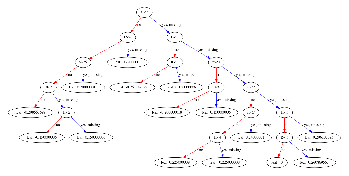

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

h = 1.0  # step size in the mesh

names = ["XGBoost"]

classifiers = [
            XGBRegressor(
            base_score=0.5, 
            booster='gblinear', 
            objective='binary:hinge',
            eval_metric='mae',
            tree_method='hist',
            validate_parameters=1
)]

x_reg=XGBRegressor(
            base_score=0.5, 
            booster='gbtree', 
            objective='binary:hinge',
            eval_metric='mae',
            tree_method='hist',
            validate_parameters=1)

#X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                        #   random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
#X += 2 * rng.uniform(size=X.shape)
#linearly_separable = (X, y)

'''datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]
'''
datasets=[df_total.iloc[:,1],df_total.iloc[:,2]]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    #  X, y = [
    # df_total.iloc[:,1],
    # df_total.iloc[:,2]
    #      ],
    # [df_total.iloc[:,0],  df_total.iloc[:,0]]

    #X = StandardScaler().fit_transform(X)
    # X_train, X_test, y_train, y_test = \
    #     train_test_split(X, y, test_size=.4, random_state=42) 
    (X_train, y_train), (X_test, y_test), (X_val, y_val)=train_test_split(file_df,train_frac=0.5,valid_frac=0.25)
    x_reg.fit(X_train, y_train)
    from xgboost import plot_tree
    plot=plot_tree(x_reg)
    plot.show()
    
    #extract first two columns
    X_train=X_train[:,:2]
    X_test=X_test[:,:2]
    #x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    #y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    x_min=0 
    x_max=12
    y_min=0 
    y_max=12
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    #ax = plt.subplot(100, 100, i)
    #ax=plt.subplot(1,1,i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
       
        #ax=plt.subplot(x_max, y_max, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [79]:
from sagemaker.xgboost.estimator import XGBoost

hyperparameters = {
        'booster':'gbtree',
        'tree_method':'rmse',
        'objective': 'binary:hinge',
        'num_round' : 135,
        'max_depth':10,
        'eta': 0.2572110893586683,
        'gamma': 0.5662623155210383,
        'eval_metric':'rmse'
    }
xgb_estimator = XGBoost(
    entry_point="source/train.py",
    hyperparameters=hyperparameters,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    framework_version="1.0-1"
)
xgb_estimator.fit({'train': path_s3,'validation': path_s3_val}, wait=True)


Creating training-job with name: sagemaker-xgboost-2020-08-20-07-07-01-890
2020-08-20 07:07:02 Starting - Starting the training job...
2020-08-20 07:07:05 Starting - Launching requested ML instances......
2020-08-20 07:08:08 Starting - Preparing the instances for training......
2020-08-20 07:09:17 Downloading - Downloading input data...
2020-08-20 07:09:42 Training - Downloading the training image...
2020-08-20 07:10:33 Uploading - Uploading generated training model
2020-08-20 07:10:33 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module train does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the followin

Training seconds: 76
Billable seconds: 76


AttributeError: 'str' object has no attribute 'get_dump'

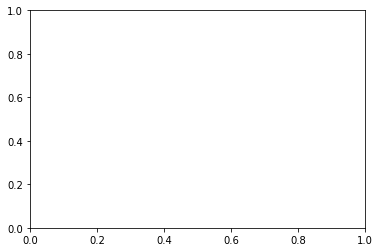

In [82]:
from xgboost import plot_tree
plot=plot_tree(xgb_estimator)
plot.show()